In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import save_model, load_model

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
import logging

from gait_modulation import FeatureExtractor2
from gait_modulation import LSTMClassifier, CustomTrainingLogger, CustomGridSearchCV
from gait_modulation.utils.utils import *

In [2]:
# Load the preprocessed data
patient_epochs = load_pkl('results/pickles/patients_epochs.pickle')
subjects_event_idx_dict = load_pkl('results/pickles/subjects_event_idx_dict.pickle')
sfreq = patient_epochs['PW_EM59'].info['sfreq']

patient_names = np.array(list(patient_epochs.keys()))

# Keep only the first three patient epochs
patient_epochs = {k: patient_epochs[k] for k in list(patient_epochs)[:3]}
patient_names = np.array(list(patient_epochs.keys()))

In [3]:
"""
# Log available devices and GPU details
def _log_device_details():
    print("Available devices:")
    for device in tf.config.list_logical_devices():
        print(device)

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("Running on GPU")
        print(f"Num GPUs Available: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            print(f"\nGPU {i} Details:")
            gpu_details = tf.config.experimental.get_device_details(gpu)
            for key, value in gpu_details.items():
                print(f"{key}: {value}")
    else:
        print("Running on CPU")

    # Log logical GPUs (useful for multi-GPU setups)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"\nLogical GPUs Available: {len(logical_gpus)}")
    for i, lgpu in enumerate(logical_gpus):
        print(f"Logical GPU {i}: {lgpu}")

# Enable device placement logging
def _configure_tf_logs():
    tf.debugging.set_log_device_placement(True)
    tf.get_logger().setLevel('ERROR')  # Options: 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'FATAL'
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logs

# Clear TensorFlow session and log build details
def _reset_tf_session():
    tf.keras.backend.clear_session()
    print("Built with CUDA:", tf.test.is_built_with_cuda())
    print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Combine all configuration and logging calls
def initialize_tf():
    _log_device_details()
    _configure_tf_logs()
    _reset_tf_session()

# Initialize TensorFlow configuration
initialize_tf()
"""

# Suppress TensorFlow logs (should be set before importing TensorFlow)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logs (0 = all, 1 = info, 2 = warnings, 3 = errors)

# Log available devices and GPU details
def _log_device_details():
    print("Available devices:")
    for device in tf.config.list_logical_devices():
        print(f"  - {device}")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"\nRunning on GPU ({len(gpus)} available):")
        for i, gpu in enumerate(gpus):
            print(f"  - GPU {i}: {gpu}")
            try:
                gpu_details = tf.config.experimental.get_device_details(gpu)
                for key, value in gpu_details.items():
                    print(f"    {key}: {value}")
            except Exception:
                print("    No additional GPU details available.")
    else:
        print("\nRunning on CPU.")

# Enable device placement logging
def _configure_tf_logs():
    tf.debugging.set_log_device_placement(True)
    tf.get_logger().setLevel('ERROR')  # Options: 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'FATAL'

# Clear TensorFlow session and log CUDA details
def _reset_tf_session():
    tf.keras.backend.clear_session()
    print("\nTensorFlow Build Details:")
    print(f"  - Built with CUDA: {tf.test.is_built_with_cuda()}")
    print(f"  - Available GPUs: {len(tf.config.list_physical_devices('GPU'))}")

# Initialize TensorFlow configuration
def initialize_tf():
    _log_device_details()
    _configure_tf_logs()
    _reset_tf_session()

# Initialize TensorFlow settings
initialize_tf()

Available devices:
  - LogicalDevice(name='/device:CPU:0', device_type='CPU')
  - LogicalDevice(name='/device:GPU:0', device_type='GPU')

Running on GPU (1 available):
  - GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
    device_name: METAL

TensorFlow Build Details:
  - Built with CUDA: False
  - Available GPUs: 1


In [4]:
# configuration for feature extraction
features_config = {
    'time_features': {
        # 'mean': True,
        # 'std': True,
        # 'median': True,
        # 'skew': True,
        # 'kurtosis': True,
        # 'rms': True
            # peak_to_peak = np.ptp(lfp_data, axis=2)
    },
    'freq_features': {
        'psd_raw': True,
            # psd_vals = np.abs(np.fft.rfft(lfp_data, axis=2))
        # 'psd_band_mean': True, band power!
        # 'psd_band_std': True,
        # 'spectral_entropy': True
    },
    # 'wavelet_features': {
    #     'energy': False
    # },
    # 'nonlinear_features': {
    #     'sample_entropy': True,
    #     'hurst_exponent': False
    # }
}


# Initialize the FeatureExtractor
feature_extractor = FeatureExtractor2(sfreq, features_config)

In [5]:
feature_handling = "flatten_chs"

n_windows_threshold = 80  # Threshold for excluding long trials

# X_grouped is a list where each element is (n_windows_per_trial, n_features)
X_grouped, y_grouped, groups = [], [], []
excluded_count = 0

for patient in patient_names:
    epochs = patient_epochs[patient]
    
    # Extract trial indices
    trial_indices = epochs.events[:, 1]  # Middle column contains trial index
    unique_trials = np.unique(trial_indices)
    # print(f"- Patient {patient} has {len(unique_trials)} trials")
    
    # Extract features and labels
    X_patient, y_patient = feature_extractor.extract_features_with_labels(
        epochs, feature_handling=feature_handling
    )
    
    # Group windows by trial
    for trial in unique_trials:
        trial_mask = trial_indices == trial  # Find windows belonging to this trial
        n_windows = sum(trial_mask)
        
        # if n_windows > n_windows_threshold:
        #     print(f"Trial {trial} has {n_windows} windows, excluding...")
        #     excluded_count += 1
        #     continue
        
        X_grouped.append(X_patient[trial_mask])  # Store all windows of this trial
        y_grouped.append(y_patient[trial_mask])  # Store labels for this trial
        groups.append(patient)  # Keep track of the patient
        
        # print(f"Trial {trial} has {n_windows} windows")
# print("Number of excluded trials:", excluded_count)

# We must pad sequences manually so that all batches have the same shape.
mask_vals = (0.0, 2) # or try to use -1 for padding labels if this does not work
# X_grouped is a list of arrays, each with shape (n_windows_per_trial, n_features)
X_padded = pad_sequences(X_grouped, dtype='float32', padding='post', value=mask_vals[0])
y_padded = pad_sequences(y_grouped, dtype='int32', padding='post', value=mask_vals[1])  # or try to use -1 for ignored labels

print("Padded X shape:", X_padded.shape)  # (n_trials, max_n_windows, n_features)
print("Padded y shape:", y_padded.shape)  # (n_trials, max_n_windows)

assert not np.any(np.isnan(X_padded)), "X_grouped contains NaNs"
assert not np.any(np.isnan(y_padded)), "y_grouped contains NaNs"

assert X_padded.shape[0] == y_padded.shape[0] == len(groups), "X, y, and groups should have the same number of trials"
assert X_padded.shape[1] == y_padded.shape[1], "X and y should have the same number of windows"

print("-" * 50)

Padded X shape: (125, 34, 294)
Padded y shape: (125, 34)
--------------------------------------------------


In [6]:
n_features = X_padded.shape[2]
n_windows = X_padded.shape[1]
input_shape = (None, n_features)  # Use None for dynamic sequence length

In [7]:
# """
# Create an instance of the LSTMClassifier
lstm_classifier = LSTMClassifier(input_shape=input_shape,
                                hidden_dims=[32, 32],
                                activations=['tanh', 'relu'],
                                recurrent_activations=['sigmoid', 'hard_sigmoid'],
                                dropout=0.2,
                                dense_units=n_windows,
                                dense_activation='sigmoid',
                                optimizer='adam',
                                lr=0.001,
                                patience=5,
                                epochs=2,
                                batch_size=128,
                                threshold=0.5,
                                loss='binary_crossentropy',
                                mask_vals=mask_vals,
                                )
        
# Fit the model on the training data
lstm_classifier.fit(X_padded, y_padded)

lstm_classifier.summary()
# tensorboard --logdir=./logs/lstm --> http://localhost:6006 in browser

# """


Training on GPU

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0480 - auc: 0.4452 - loss: 0.7107 - precision: 0.5232 - recall: 0.4992
[Fold 0] [Epoch 1/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0480 - auc: 0.4452 - loss: 0.7107 - precision: 0.5232 - recall: 0.4992 - learning_rate: 0.0010
Epoch 2/2

[Fold 0] [Epoch 2/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0240 - auc: 0.4741 - loss: 0.7037 - precision: 0.5470 - recall: 0.5084
[Fold 0] [Epoch 2/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0240 - auc: 0.4741 - loss: 0.7037 - precision: 0.5470 - recall: 0.5084 - learning_rate: 0.0010


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 294)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 32)       │        41,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         1,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,896 (601.16 KB)

 Trainable params: 51,298 (200.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 102,598 (400.78 KB)

# GridSearchCV and LeaveOneGroupOut (logo)

In [8]:
# ----------------------------------------------------------------------------- #
# -----------------------  LSTMClassifier Grid Search  -----------------------  #
# ----------------------------------------------------------------------------- #

In [9]:
initialize_tf()

Available devices:
  - LogicalDevice(name='/device:CPU:0', device_type='CPU')
  - LogicalDevice(name='/device:GPU:0', device_type='GPU')

Running on GPU (1 available):
  - GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
    device_name: METAL

TensorFlow Build Details:
  - Built with CUDA: False
  - Available GPUs: 1


In [10]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_dir = os.path.join("logs", "lstm", "models", f"logs_run_{timestamp}")
os.makedirs(model_dir, exist_ok=True)

# Create logs directory
log_dir = os.path.join(model_dir, "logs")
os.makedirs(log_dir, exist_ok=True)

# Configure logging
logging.basicConfig(
    filename=os.path.join(log_dir, "training.log"),
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

# Console logging
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
console_handler.setFormatter(formatter)
logging.getLogger().addHandler(console_handler)

logging.info("Logging setup complete. Starting training process.")


In [11]:
# X, y, groups = [], [], []
# for patient in patient_names:
#     epochs = patient_epochs[patient]
#     X_patient, y_patient = feature_extractor.extract_features_with_labels(
#         epochs, feature_handling="flatten_chs"
#     )
#     X.append(X_patient)
#     y.append(y_patient)
#     groups.extend([patient] * len(y_patient))

# X = np.concatenate(X, axis=0)
# y = np.concatenate(y, axis=0)
# assert len(X) == len(y) == len(groups), "Mismatch in lengths of X, y, and groups."
# X = np.concatenate(X, axis=0) if X else np.array([])
# y = np.concatenate(y, axis=0) if y else np.array([])

# print("Number of excluded trials:", excluded_count)

# print("Padded X shape:", X_padded.shape)  # (n_trials, max_n_windows, n_features)
# print("Padded y shape:", y_padded.shape)  # (n_trials, max_n_windows)
# print(f"y_padded_flat shape: {y_padded_flat.shape}")

# feature_selection_methods = {
#     'select_k_best': SelectKBest(score_func=f_classif),
#     'pca': PCA(),
#     'model_based': SelectFromModel(RandomForestClassifier(n_estimators=100))
# }

# Define candidate models for classification
models = {
    'lstm': LSTMClassifier(input_shape=input_shape)
}

# Build a pipeline with placeholders for feature selection and classifier
# Remove constant features before feature selection (Remove features with zero variance)
pipeline = Pipeline([
    ('scaler', 'passthrough'),
    # ('variance_threshold', VarianceThreshold(threshold=0.0)),
    # ('feature_selection', 'passthrough'),
    ('classifier', models['lstm'])
])

# Define parameter grid as a list of dictionaries
param_grid = [      
    {
        # 'feature_selection': ['passthrough'],  # No feature selection for LSTM
        # 'classifier': [models['lstm']],
        'classifier__hidden_dims': [[32, 32]], # [[32], [64], [32, 64], [64, 128]]
        'classifier__activations': [['tanh', 'relu']],
        'classifier__recurrent_activations': [['sigmoid', 'hard_sigmoid']],
        'classifier__dropout': [0.2],
        'classifier__dense_units': [n_windows],
        'classifier__dense_activation': ['sigmoid'],
        'classifier__optimizer': ['adam'],
        'classifier__lr': [0.001],
        'classifier__patience': [10],
        'classifier__epochs': [2],
        'classifier__batch_size': [128],
        'classifier__threshold': [0.5],
        'classifier__loss': ['binary_crossentropy'],
        'classifier__mask_vals': [mask_vals],
    }
]

# Define scoring metrics
# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'f1': make_scorer(f1_score, average='weighted'),
# }
def masked_accuracy_score(y_true, y_pred):
    mask = y_true != mask_vals[1] # or try to use -1 for ignored labels
    return accuracy_score(y_true[mask], y_pred[mask])

def masked_f1_score(y_true, y_pred):
    mask = y_true != mask_vals[1] # or try to use -1 for ignored labels
    return f1_score(y_true[mask], y_pred[mask], average='weighted')

def masked_roc_auc_score(y_true, y_pred):
    mask = y_true != mask_vals[1] # or try to use -1 for ignored labels
    return roc_auc_score(y_true[mask], y_pred[mask])

def masked_classification_report(y_true, y_pred, target_names=None, digits=4):
    mask = y_true != mask_vals[1] # or try to use -1 for ignored labels
    return classification_report(y_true[mask], y_pred[mask], target_names=target_names, digits=digits)

def masked_confusion_matrix(y_true, y_pred):
    mask = y_true != mask_vals[1] # or try to use -1 for ignored labels
    return confusion_matrix(y_true[mask], y_pred[mask])


# Define custom scoring metrics
scoring = {
    'accuracy': make_scorer(masked_accuracy_score),
    'f1': make_scorer(masked_f1_score),
}

# Add roc_auc only for models supporting predict_proba
if any(hasattr(model, "predict_proba") for model in models.values()):
    # scoring['roc_auc'] = make_scorer(roc_auc_score,
    #                                  response_method='predict_proba',
    #                                  multi_class='ovr')
    scoring['roc_auc'] = make_scorer(masked_roc_auc_score,
                                     needs_proba=True,
                                    #  needs_threshold=True,
                                     multi_class='ovr')
    
# Estimate total fits: n_splits * n_params
logo = LeaveOneGroupOut()
n_splits = logo.get_n_splits(X_padded, y_padded, groups)
n_params = len(param_grid)
total_fits = n_splits * n_params
print(f"Total fits: {total_fits}")
print(f"Number of splits: {n_splits}, Number of parameters: {n_params}")

logging.info("Starting Grid Search...")

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=logo,
    scoring=scoring,
    refit='f1' if 'f1' in scoring else 'accuracy',
    n_jobs=-1,
    verbose=3,
    # error_score='raise',
)

# grid_search = CustomGridSearchCV(
#     pipeline,
#     param_grid=param_grid,
#     cv=logo,
#     scoring=scoring,
#     refit='f1' if 'f1' in scoring else 'accuracy',
#     n_jobs=-1,
#     verbose=3,
#     # error_score='raise',
# )
#     # Define fit_params
# fit_params = {
#     'callbacks': [CustomTrainingLogger()]
# }



Total fits: 3
Number of splits: 3, Number of parameters: 1


/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [12]:
grid_search.fit(X_padded, y_padded, groups=groups)
# grid_search.fit(X_padded, y_padded, groups=groups, **fit_params)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training on GPU
Training on GPU
Training on GPU

---- Starting Training for Fold 0 ----

---- Starting Training for Fold 0 ----


Epoch 1/2
Epoch 1/2

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [Epoch 1/2] [Batch 1/1]: 

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0465 - auc: 0.4894 - loss: 0.6990 - precision: 0.5886 - recall: 0.4399
[Fold 0] [Epoch 1/2]: 

[Fold 0] [Epoch 1/2]: 

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0625 - auc: 0.6034 - loss: 0.6864 - precision: 0.6081 - recall: 0.6132
[Fold 0] [Epoch 1/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0441 - auc: 0.5340 - loss: 0.6905 - precision: 0.5620 - recall: 0.4738 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0465 - auc: 0.4894 - loss: 0.6990 - precision: 0.5886 - recall: 0.4399 - learning_rate: 0.0010
Epoch 2/2
Epoch 2/2
1/1 ━━━━━━

/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
TypeError: masked_roc_auc_score() got an unexpected keyword argument 'multi_class'

  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
[CV 1/3] END classifier__activations=['tanh', 'relu'], classifier__batch_size=128, classifier__dense_activation=sigmoid, classifier__dense_units=34, classifier__dropout=0.2, classifier__epochs=2, classifier__hidden_dims=[32, 32], classifier__loss=binary_crossentropy, classifier__lr=0.001, classifier__mask_vals=(0.0, 2), classifier__optimizer=adam, classifier__patience=10, classifier__recurrent_activations=['sigmoid', 'hard_sigmoid'], classifier__threshold=0.5; accuracy: (test=0.552) f1: (test=0.558) roc_auc: (test=nan) total time=  13.0s


/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
TypeError: masked_roc_auc_score() got an unexpected keyword argument 'multi_class'

  warnings.warn(
/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
[CV 2/3] END classifier__activations=['tanh', 'relu'], classifier__batch_size=128, classifier__dense_activation=sigmoid, classifier__dense_units=34, classifier__dropout=0.2, classifier__epochs=2, classifier__hidden_dims=[32, 32], classifier__loss=binary_crossentropy, classifier__lr=0.001, classifier__mask_vals=(0.0, 2), classifier__optimizer=adam, classifier__patience=10, classifier__recurrent_activations=['sigmoid', 'hard_sigmoid'], classifier__threshold=0.5; accuracy: (test=0.579) f1: (test=0.583) roc_auc: (test=nan) total time=  13.0s
Training on GPU

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0160 - auc: 0.3941 - loss: 0.7301 - precision: 0.4871 - recall: 0.4193
[Fold 0] [Epoch 1/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0160 - auc: 0.3941 - loss: 0.7301 - precision: 0.4871 - recall: 0.4193 - learning_rate: 0.0010
Epoch 2/2

[Fold 0] [Epoc

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('classifier',
                                        LSTMClassifier(callbacks=[],
                                                       input_shape=(None,
                                                                    294)))]),
             n_jobs=-1,
             param_grid=[{'classifier__activations': [['tanh', 'relu']],
                          'classifier__batch_size': [128],
                          'classifier__dense_activation': ['sigmoid'],
                          'classifier__dense_units': [34],
                          'classifier__dropout': [...
                          'classifier__recurrent_activations': [['sigmoid',
                                                                 'hard_sigmoid']],
                          'classifier__threshold': [0.5]}],
             refit='f1',
             scoring={'accuracy': make_scorer(masked_accuracy_score, response_method='predict'),
                      'f1': make_scorer(masked_f1_score, response_method='predict'),
                      'roc_auc': make_scorer(masked_roc_auc_score, response_method='predict_proba', multi_class=ovr)},
             verbose=3)

In [13]:
# Log best parameters
logging.info(f"Best Parameters: {grid_search.best_params_}")
logging.info(f"Best Score: {grid_search.best_score_:.4f}")

# Save best model
best_model_path = os.path.join(model_dir, "best_lstm_model.h5")
best_model = grid_search.best_estimator_.named_steps['classifier'].model
best_model.save(best_model_path)

keras_model_path = os.path.join(model_dir, 'best_lstm_model.keras')
save_model(best_model, keras_model_path)


logging.info(f"Best LSTM model saved at {best_model_path}.")

2025-03-15 03:55:17,859 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


In [15]:
# Average performance per hyperparameter set across all folds.

# Convert GridSearchCV results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns
# results_df = results_df[
#     [
#         "mean_test_score",  # Mean score across folds
#         "std_test_score",   # Standard deviation across folds
#         "mean_test_f1_weighted",
#         "mean_test_roc_auc",
#         "params",            # Hyperparameter combination
#     ]
# ]

# # Sort by best mean test score
# results_df = results_df.sort_values(by="mean_test_score", ascending=False)

# Display top results
# print(results_df.head())
results_df.T

,0
mean_fit_time,11.52892
std_fit_time,0.084017
mean_score_time,1.277279
std_score_time,0.355045
param_classifier__activations,"[tanh, relu]"
param_classifier__batch_size,128
param_classifier__dense_activation,sigmoid
param_classifier__dense_units,34
param_classifier__dropout,0.2
param_classifier__epochs,2


In [16]:
grid_search.best_estimator_.named_steps['classifier'].model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 294)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 32)       │        41,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         1,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,896 (601.16 KB)

 Trainable params: 51,298 (200.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 102,598 (400.78 KB)

In [17]:
# Get Best Parameters & Best Score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'classifier__activations': ['tanh', 'relu'], 'classifier__batch_size': 128, 'classifier__dense_activation': 'sigmoid', 'classifier__dense_units': 34, 'classifier__dropout': 0.2, 'classifier__epochs': 2, 'classifier__hidden_dims': [32, 32], 'classifier__loss': 'binary_crossentropy', 'classifier__lr': 0.001, 'classifier__mask_vals': (0.0, 2), 'classifier__optimizer': 'adam', 'classifier__patience': 10, 'classifier__recurrent_activations': ['sigmoid', 'hard_sigmoid'], 'classifier__threshold': 0.5}
Best Cross-Validation Accuracy: 0.5882


In [18]:
from tensorflow.keras.models import load_model

# Load the model with custom objects
custom_objects = {
    'masked_loss_binary_crossentropy': LSTMClassifier.masked_loss_binary_crossentropy,
}

loaded_h5_model = load_model(best_model_path, custom_objects=custom_objects)
print(loaded_h5_model.summary())

# Load the models
# keras_model = load_model(keras_model_path)

# print(keras_model.summary())

2025-03-15 03:56:34,839 - WARNING - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, None, 294)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 32)       │        41,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 34)             │         1,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,300 (200.39 KB)

 Trainable params: 51,298 (200.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


# Evaluation

In [19]:
y_tests = []
y_preds = []

# Retrieve the best estimator from GridSearchCV
best_estimator = grid_search.best_estimator_

n_splits = logo.get_n_splits(X_padded, y_padded, groups)

# Manually split the data using the cross-validation strategy
for fold, (train_idx, test_idx) in enumerate(logo.split(X_padded, y_padded, groups)):
    print(f"\n---- Evaluating Fold {fold + 1}/{n_splits} ----\n")
    
    # Split the data into training and test sets
    X_train, X_test = X_padded[train_idx], X_padded[test_idx]
    y_train, y_test = y_padded[train_idx], y_padded[test_idx]
    
    # Train the best estimator on the training set
    best_estimator.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = best_estimator.predict(X_test)
    
    # Store the true labels and predictions
    y_tests.append(y_test)
    y_preds.append(y_pred)
    
    # Evaluate the model
    accuracy = masked_accuracy_score(y_test, y_pred)
    f1 = masked_f1_score(y_test, y_pred)
    roc_auc = masked_roc_auc_score(y_test, y_pred)
    
    
    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f} ROC AUC: {roc_auc:.4f}")

# Concatenate all true labels and predictions
y_tests = np.concatenate(y_tests, axis=0)
y_preds = np.concatenate(y_preds, axis=0)

# Overall evaluation
overall_accuracy = masked_accuracy_score(y_tests, y_preds)
overall_f1 = masked_f1_score(y_tests, y_preds)
overall_roc_auc = masked_roc_auc_score(y_tests, y_preds)

print(f"\nOverall Accuracy: {overall_accuracy:.4f}, Overall F1 Score: {overall_f1:.4f} Overall ROC AUC: {overall_roc_auc:.4f}")


---- Evaluating Fold 1/3 ----

Training on GPU

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0147 - auc_1: 0.4802 - loss: 0.6944 - precision_1: 0.5277 - recall_1: 0.4465
[Fold 0] [Epoch 1/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0147 - auc_1: 0.4802 - loss: 0.6944 - precision_1: 0.5277 - recall_1: 0.4465 - learning_rate: 0.0010
Epoch 2/2

[Fold 0] [Epoch 2/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0000e+00 - auc_1: 0.5217 - loss: 0.6862 - precision_1: 0.5615 - recall_1: 0.4598
[Fold 0] [Epoch 2/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - auc_1: 0.5217 - loss: 0.6862 - precision_1: 0.5615 - recall_1: 0.4598 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
Fold 1 - Accuracy: 0.5478, F1 Score: 0.5554 ROC AUC: 0.5413

---- Evaluating Fold 2/3 ----

Training on GPU

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [

In [20]:
# cross_val_score for Aggregated Performance
from sklearn.model_selection import cross_val_score

best_model = grid_search.best_estimator_  # Best model from GridSearchCV

# Compute F1-score (or another metric) using cross-validation
# mean and standard deviation of the metric across different folds
f1_scores = cross_val_score(best_model, X_padded, y_padded,
                            cv=logo, groups=groups,
                            scoring=make_scorer(masked_f1_score), n_jobs=-1)

accuracy_scores = cross_val_score(best_model, X_padded, y_padded,
                                  cv=logo, groups=groups,
                                  scoring=make_scorer(masked_accuracy_score), n_jobs=-1)

roc_auc_scores = cross_val_score(best_model, X_padded, y_padded,
                                cv=logo, groups=groups,
                                scoring=make_scorer(masked_roc_auc_score), n_jobs=-1)


print(f"Mean F1-score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
print(f"Mean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
print(f"Mean ROC AUC: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")

Training on GPU
Training on GPU
Training on GPU

---- Starting Training for Fold 0 ----

Epoch 1/2

---- Starting Training for Fold 0 ----

Epoch 1/2

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0000e+00 - auc: 0.4010 - loss: 0.7049 - precision: 0.4890 - recall: 0.2847
[Fold 0] [Epoch 1/2] [Batch 1/1]: 

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0294 - auc: 0.5722 - loss: 0.6852 - precision: 0.5993 - recall: 0.5418
[Fold 0] [Epoch 1/2]: 

[Fold 0] [Epoch 1/2]: 

[Fold 0] [Epoch 1/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0000e+00 - auc: 0.4010 - loss: 0.7049 - precision: 0.4890 - recall: 0.2847 - learning_rate: 0.0010
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0625 - auc: 0.5727 - loss: 0.6807 - precision: 0.6072 - recall: 0.5020 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0294 - auc: 0.5722 - 

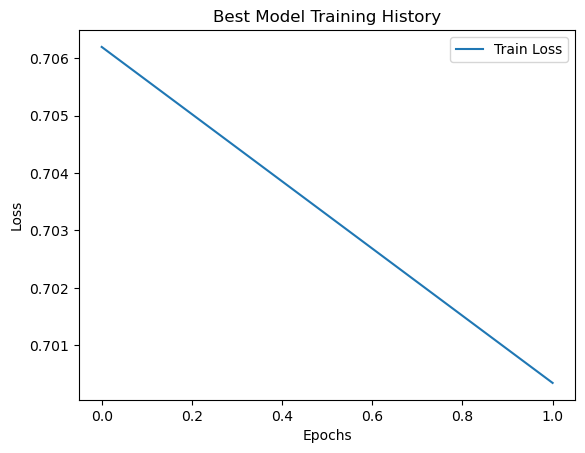

In [21]:
# Access the training history of the best model
best_history = grid_search.best_estimator_.named_steps['classifier'].history_

plt.plot(best_history['loss'], label='Train Loss')
# plt.plot(best_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Best Model Training History')
plt.show()

In [22]:
print(f"Mean F1-score: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
print(f"Mean Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
print(f"Mean ROC AUC: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")
f1_scores, accuracy_scores, roc_auc_scores

Mean F1-score: 0.6217 ± 0.0378
Mean Accuracy: 0.5377 ± 0.0618
Mean ROC AUC: 0.5055 ± 0.0660


(array([0.63543949, 0.57008797, 0.65959775]),
 array([0.59908187, 0.45316935, 0.56079027]),
 array([0.41281741, 0.54234772, 0.56128649]))

In [23]:
from sklearn.model_selection import cross_val_predict

# This will return predictions where each test fold (left-out group) is predicted by the best estimator trained on the remaining groups.
y_pred = cross_val_predict(best_estimator, X_padded, y_padded, cv=logo, groups=groups) # Get predicted labels

# Initialize lists to store scores
f1_scores = []
accuracy_scores = []
roc_auc_scores = []

# Evaluate per patient (group)
for patient in np.unique(groups):
    patient_mask = np.array(groups) == patient
    y_true_patient = y_padded[patient_mask]
    y_pred_patient = y_pred[patient_mask]

    f1 = masked_f1_score(y_true_patient, y_pred_patient)
    acc = masked_accuracy_score(y_true_patient, y_pred_patient)
    roc_auc = masked_roc_auc_score(y_true_patient, y_pred_patient)

    f1_scores.append(f1)
    accuracy_scores.append(acc)
    roc_auc_scores.append(roc_auc)

    print(f"Patient {patient}: Accuracy = {acc:.4f}, F1-score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

# Calculate and print mean and standard deviation of scores
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)

mean_roc_auc = np.mean(roc_auc_scores)
std_roc_auc = np.std(roc_auc_scores)

print(f"\nMean F1-score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")


Training on GPU

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0294 - auc_4: 0.5713 - loss: 0.6893 - precision_4: 0.5993 - recall_4: 0.5301
[Fold 0] [Epoch 1/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0294 - auc_4: 0.5713 - loss: 0.6893 - precision_4: 0.5993 - recall_4: 0.5301 - learning_rate: 0.0010
Epoch 2/2

[Fold 0] [Epoch 2/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0588 - auc_4: 0.5980 - loss: 0.6830 - precision_4: 0.6288 - recall_4: 0.5222
[Fold 0] [Epoch 2/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0588 - auc_4: 0.5980 - loss: 0.6830 - precision_4: 0.6288 - recall_4: 0.5222 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Training on GPU

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0814 - auc_5: 0.5632 - loss: 0.6900 - precision_5: 0.6289

In [24]:
y_padded.shape, y_pred.shape
# y_pred, y_padded

((125, 34), (125, 34))

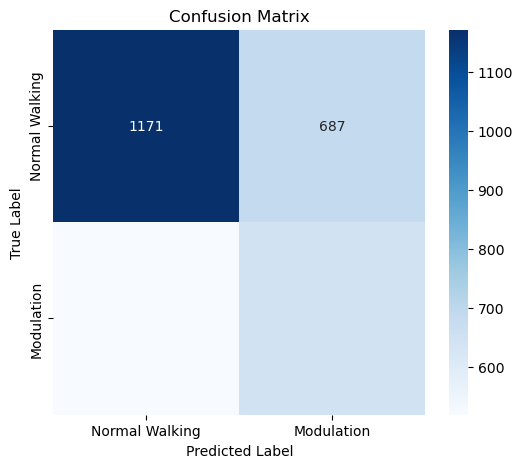

In [25]:
import seaborn as sns

# Mask the values
mask = y_padded != mask_vals[1]
y_true_masked = y_padded[mask]
y_pred_masked = y_pred[mask]

# Compute confusion matrix
cm = confusion_matrix(y_true_masked, y_pred_masked)

# Plot using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Walking', 'Modulation'], yticklabels=['Normal Walking', 'Modulation'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
print("Classification Report:")
print(classification_report(y_true_masked, y_pred_masked, target_names=['Normal Walking', 'Modulation']))

Classification Report:
                precision    recall  f1-score   support

Normal Walking       0.69      0.63      0.66      1858
    Modulation       0.48      0.55      0.52      1164

      accuracy                           0.60      3022
     macro avg       0.59      0.59      0.59      3022
  weighted avg       0.61      0.60      0.60      3022



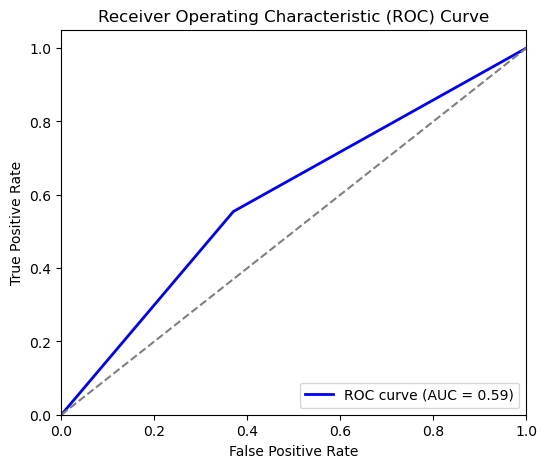

In [27]:
from sklearn.metrics import roc_curve, auc

if y_pred is not None:
    fpr, tpr, _ = roc_curve(y_true_masked, y_pred_masked)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random chance)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC Curve & AUC cannot be computed because the model does not support probability predictions.")

# 2. Analyze Cross-Validation Performance

In [28]:
# Get Best Parameters & Best Score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'classifier__activations': ['tanh', 'relu'], 'classifier__batch_size': 128, 'classifier__dense_activation': 'sigmoid', 'classifier__dense_units': 34, 'classifier__dropout': 0.2, 'classifier__epochs': 2, 'classifier__hidden_dims': [32, 32], 'classifier__loss': 'binary_crossentropy', 'classifier__lr': 0.001, 'classifier__mask_vals': (0.0, 2), 'classifier__optimizer': 'adam', 'classifier__patience': 10, 'classifier__recurrent_activations': ['sigmoid', 'hard_sigmoid'], 'classifier__threshold': 0.5}
Best Cross-Validation Accuracy: 0.5882


# 3. Evaluate Generalization Across Folds

In [30]:
# To evaluate performance for each "left-out" patient
for train_idx, test_idx in logo.split(X_padded, y_padded, groups=groups):
    model = grid_search.best_estimator_
    model.fit(X_padded[train_idx], y_padded[train_idx])  # Train on the training fold
    y_pred = model.predict(X_padded[test_idx])  # Predict on the test fold

    # Calculate masked accuracy
    accuracy = masked_accuracy_score(y_padded[test_idx], y_pred)
    f1 = masked_f1_score(y_padded[test_idx], y_pred)
    roc_auc = masked_roc_auc_score(y_padded[test_idx], y_pred)
    
    print(f"Test Accuracy for group {groups[test_idx[0]]}: {accuracy:.4f}")
    print(f"Test F1 Score for group {groups[test_idx[0]]}: {f1:.4f}")
    print(f"Test ROC AUC for group {groups[test_idx[0]]}: {roc_auc:.4f}")
    print(f"classification report for group {groups[test_idx[0]]}:")
    print("==" * 30)
    print(masked_classification_report(y_padded[test_idx], y_pred, target_names=['Normal Walking', 'Modulation']))
    print(f"confusion matrix for group {groups[test_idx[0]]}:")
    print(masked_confusion_matrix(y_padded[test_idx], y_pred))
    print("=" * 30)

Training on GPU

---- Starting Training for Fold 0 ----

Epoch 1/2

[Fold 0] [Epoch 1/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0000e+00 - auc_10: 0.5176 - loss: 0.7001 - precision_10: 0.5748 - recall_10: 0.4980
[Fold 0] [Epoch 1/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - auc_10: 0.5176 - loss: 0.7001 - precision_10: 0.5748 - recall_10: 0.4980 - learning_rate: 0.0010
Epoch 2/2

[Fold 0] [Epoch 2/2] [Batch 1/1]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0294 - auc_10: 0.5460 - loss: 0.6920 - precision_10: 0.5920 - recall_10: 0.4996
[Fold 0] [Epoch 2/2]: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0294 - auc_10: 0.5460 - loss: 0.6920 - precision_10: 0.5920 - recall_10: 0.4996 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Test Accuracy for group PW_FH57: 0.6236
Test F1 Score for group PW_FH57: 0.6283
Test ROC AUC for group PW_FH57: 0.6116
classification report for group PW_FH57:
                precision    r

# 4. Feature Importance

In [31]:
import matplotlib.pyplot as plt

# Extract the classifier from the pipeline
model = grid_search.best_estimator_['classifier']

if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(importances)), importances)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances Plot')
    plt.show()

elif hasattr(model, 'coef_'):
    importances = model.coef_[0]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(importances)), importances)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.title('Model Coefficient Plot')
    plt.show()

else:
    print("Model does not support feature importances or coefficients.")

Model does not support feature importances or coefficients.


# 5. Learning Curves

In [32]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Evaluate if the model is overfitting or underfitting:
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_,
    X_train,
    y_train,
    groups=groups,  # <- Pass your groups array here
    cv=logo,
    scoring='accuracy',
    n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [96, 96, 125]

# 6. Error Analysis

In [33]:
# Inspect Misclassified Samples
misclassified = np.where(y_test != y_pred)[0]
print(f"Misclassified indices: {misclassified}")
print(f"True labels: {y_test[misclassified]}")
print(f"Predicted labels: {y_pred[misclassified]}")


Misclassified indices: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14
 14 14 14 14 14 14 14 14 14 